# Result for **ResNet18+Cifar10**
### This notebook is for seed $42$. The results in the paper are the average of $5$ times with seeds in $[1, 19, 31, 42, 80]$

## Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import os
import random
import numpy as np
import pandas as pd
import copy

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowExxb
  Referenced from: /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torchvision/image.so
  Expected in: /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/lib/libc10.dylib
  warn(f"Failed to load image Python extension: {e}")


## Models

In [3]:
"""resnet in pytorch
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun.
    Deep Residual Learning for Image Recognition
    https://arxiv.org/abs/1512.03385v1
"""
class BasicBlock(nn.Module):
    """Basic Block for resnet 18 and resnet 34
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()

        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BasicBlock.expansion, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels * BasicBlock.expansion)
        )
        self.shortcut = nn.Sequential()

        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )
    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


class BottleNeck(nn.Module):
    """Residual block for resnet over 50 layers
    """
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleNeck, self).__init__()
        self.residual_function = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, stride=stride, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels * BottleNeck.expansion, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels * BottleNeck.expansion),
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * BottleNeck.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_channels * BottleNeck.expansion)
            )
    def forward(self, x):
        return nn.ReLU(inplace=True)(self.residual_function(x) + self.shortcut(x))


class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True))
        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make_layer(block, 256, num_block[2], 2)
        self.conv5_x = self._make_layer(block, 512, num_block[3], 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
    def _make_layer(self, block, out_channels, num_blocks, stride):
        """make resnet layers(by layer i didnt mean this 'layer' was the
        same as a neuron netowork layer, ex. conv layer), one layer may
        contain more than one residual block
        Args:
            block: block type, basic block or bottle neck block
            out_channels: output depth channel number of this layer
            num_blocks: how many blocks per layer
            stride: the stride of the first block of this layer
        Return:
            return a resnet layer
        """
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)
    def forward(self, x):
        output = self.conv1(x)
        output = self.conv2_x(output)
        output = self.conv3_x(output)
        output = self.conv4_x(output)
        output = self.conv5_x(output)
        output = self.avg_pool(output)
        output = output.view(output.size(0), -1)
        output = self.fc(output)
        return output


def resnet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def resnet18_copy():
    return ResNet(BasicBlock, [2, 2, 2, 2])

## Prepare data

In [4]:
def create_loaders(dataset_name, n_workers, batch_size):
    train_data, test_data = load_data(dataset_name)
    train_loader_workers = dict()
    n = len(train_data)
    
    # preparing iterators for workers
    indices = np.arange(n)
    np.random.shuffle(indices)
    a = np.int64(np.floor(n / n_workers))
    top_ind = a * n_workers
    seq = range(a, top_ind, a)
    split = np.split(indices[:top_ind], seq)
    b = 0
    for ind in split:
        train_loader_workers[b] = DataLoader(Subset(train_data, ind), batch_size=batch_size, shuffle=True)
        b = b + 1
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader_workers, test_loader


def load_data(dataset_name):
    if dataset_name == 'mnist':
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        train_data = datasets.MNIST(root='./data', train=True,
                                    download=True, transform=transform)
        test_data = datasets.MNIST(root='./data', train=False,
                                   download=True, transform=transform)

    elif dataset_name == 'cifar10':
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
        ])
        train_data = datasets.CIFAR10(root='./data', train=True,
                                      download=True, transform=transform_train)
        test_data = datasets.CIFAR10(root='./data', train=False,
                                     download=True, transform=transform_test)

    elif dataset_name == 'cifar100':
        transform_train = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343],
                                 std=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343])
        ])
        transform_test = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343],
                                 std=[0.5070751592371323, 0.48654887331495095, 0.4409178433670343])
        ])
        train_data = datasets.CIFAR100(root='./data', train=True,
                                       download=True, transform=transform_train)
        test_data = datasets.CIFAR100(root='./data', train=False,
                                      download=True, transform=transform_test)

    else:
        raise ValueError(dataset_name + ' is not known.')

    return train_data, test_data

## Parameter and Setup

In [5]:
# Hyperparameters
RANDOM_SEED = 42
lr = 0.01
BATCH_SIZE = 10
NUM_EPOCHS = 30
NUM_WORKERS = 10
D = 10  # compute thread
h = 0.01  # sparse level 99%
h_g = 0.005  # sparse level 99%


if not os.path.exists('result'):
    os.mkdir('result')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", DEVICE)

Using device:  cpu


## Functions

In [5]:
def seed_torch(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    
def evaluate_accuracy(model, data_iter, device):
    correct = 0
    for image, label in data_iter:
        image, label = image.to(device), label.to(device)
        output = model(image)
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(label.view_as(pred)).sum().item()
    accuracy = 100. * correct / len(data_iter.dataset)
    return accuracy


# Top_k sparse
def prep_grad(x):
    x_flat = torch.unsqueeze(x, 0).flatten()
    dim = x.shape
    d = x_flat.shape[0]
    return x_flat, dim, d


def top_k_opt(x, h):
    """
    :param x: vector to sparsify
    :param h: density
    :return: compressed vector
    """
    x, dim, d = prep_grad(x)
    # number of coordinates kept
    r = int(np.maximum(1, np.floor(d * h)))
    # positions of top_k coordinates
    _, ind = torch.topk(torch.abs(x), r)
    mask = torch.zeros_like(x)
    mask[ind] = 1
    t = mask * x
    t = t.reshape(dim)
    return t


def compt(old, new):
    result = 0.0
    for i in range(len(old)):
        result += ((old[i].view(-1) - new[i].view(-1)) ** 2).sum().item()
    return result


def adjust_lr(epoch_input):
    lr_ad, lr_th = 0.01, 0.01
    if epoch_input >= 20:
        lr_ad = 0.001
    if epoch_input > 20:
        lr_th = 0.001
    return lr_ad, lr_th

TASGS

In [ ]:
print("TASGS  lr:"+str(lr)+"--h:"+str(h)+"--epoch:"+str(NUM_EPOCHS)+"--worker:"+str(NUM_WORKERS))
seed_torch(RANDOM_SEED)
model = resnet18()
model.to(DEVICE)
model_copy = resnet18_copy()
model_copy.to(DEVICE)
loss = nn.CrossEntropyLoss()  # 损失函数

# prepare data
dataset_name = 'cifar10'
train_loader_workers, test_loader = create_loaders(dataset_name, NUM_WORKERS, BATCH_SIZE)

NUM_PARAS = sum([1 for param in model.parameters()])
print("Number_parameter:", NUM_PARAS)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Element_parameter:", total_params)
total_params_sparse = 0
for p in model.parameters():
    x, dim, d = prep_grad(p)
    r = int(np.maximum(1, np.floor(d * h)))
    total_params_sparse += r
print("Element_parameter_sparse:", total_params_sparse)

state_dict = [0 for col in range(NUM_WORKERS)]
grad_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
grad_gtworker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]#col是列，row是行  新加的！！！！
error_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
error_gtworker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]# 新加的！！！！
grad_old = [0 for col in range(NUM_PARAS)]
grad_new = [0 for col in range(NUM_PARAS)]
para_store = [0 for col in range(NUM_PARAS)]
tau = [0 for col in range(NUM_WORKERS)]
para_list = []
Skip_epoch = []
Loss_epoch = []
train_acc_epoch = []
test_acc_epoch = []
Skip_iter = []
Loss_iter = []
train_acc_iter = []
test_acc_iter = []

iter_num = 0
skip_iter = 0
flag_acc = False

for epoch in range(NUM_EPOCHS):
    train_l_sum, train_acc_sum, num = 0.0, 0.0, 0
    train_loader_iter = [iter(train_loader_workers[w]) for w in range(NUM_WORKERS)]
    iter_steps = len(train_loader_workers[0])
    skip_num = [[0 for col in range(iter_steps)] for row in range(NUM_EPOCHS)]
    
    # adjust learning_rate
    lr, lr_thead = adjust_lr(epoch)
    print("EPOCH: ", epoch + 1, "learning rate: ", lr)
    
    for batch_idx in range(iter_steps):
        model.train()
        model_copy.train()
        grad_agg = [0 for col in range(NUM_PARAS)]
        grad_gtagg = [0 for col in range(NUM_PARAS)]#新加的！！！！！
        skip_idx = 0
        if (epoch * iter_steps + batch_idx) < D:
            for w_id in range(NUM_WORKERS):
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()
                
                with torch.no_grad():
                    p_id = 0
                    for p in model.parameters():
                        g = lr * p.grad.data.clone().detach() + error_gtworker[w_id][p_id]
                        Tk_sparse = top_k_opt(g, h)
                        grad_agg[p_id] += Tk_sparse
                        error_worker[w_id][p_id] = g - Tk_sparse
                        grad_worker[w_id][p_id] = Tk_sparse
                        GTk_sparse = top_k_opt(grad_worker[w_id][p_id], h)#111111
                        grad_gtagg[p_id] += GTk_sparse#11111111
                        error_gtworker[w_id][p_id] = error_worker[w_id][p_id] + (Tk_sparse - GTk_sparse)#1111111
                        grad_gtworker[w_id][p_id] = GTk_sparse#1111111
                        p_id += 1
                        p.grad.zero_()
                state_dict[w_id] = copy.deepcopy(model.state_dict())
                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
        else:
            thread = 0.0
            with torch.no_grad():
                for i in range(len(para_list) - 1):
                    thread += compt(para_list[i], para_list[i + 1])
            thread = thread / (lr_thead * (NUM_WORKERS ** 2))
            for w_id in range(NUM_WORKERS):
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                model_copy.load_state_dict(state_dict[w_id])
                y_copy = model_copy(images)
                Loss_copy = loss(y_copy, labels)
                Loss_copy.backward()
                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()
                with torch.no_grad():
                    p_old_id = 0
                    grad_gtagg = [0 for col in range(NUM_PARAS)]#新加的！！！！！
                    for p_old in model_copy.parameters():
                        grad_old[p_old_id] = p_old.grad.data.clone().detach()
                        p_old_id += 1
                        p_old.grad.zero_()
                    p_id = 0
                    for p in model.parameters():
                        grad_new[p_id] = p.grad.data.clone().detach()
                        p_id += 1
                    if compt(grad_old, grad_new) > thread or tau[w_id] > D:
                        tau[w_id] = 1
                        p_id = 0
                        for p in model.parameters():
                            g = lr * p.grad.data.clone().detach() + error_gtworker[w_id][p_id]
                            Tk_sparse = top_k_opt(g, h)
                            grad_agg[p_id] += Tk_sparse
                            error_worker[w_id][p_id] = g - Tk_sparse
                            grad_worker[w_id][p_id] = Tk_sparse
                            GTk_sparse = top_k_opt(grad_worker[w_id][p_id], h)#1111112
                            grad_gtagg[p_id] += GTk_sparse#111111112
                            error_gtworker[w_id][p_id] = error_worker[w_id][p_id] + (Tk_sparse - GTk_sparse)#11111112
                            grad_gtworker[w_id][p_id] = GTk_sparse#11111112
                            p_id += 1
                            p.grad.zero_()
                        state_dict[w_id] = copy.deepcopy(model.state_dict())
                    else:
                        skip_idx += 1
                        tau[w_id] += 1
                        p_id = 0
                        for p in model.parameters():
                            grad_agg[p_id] += grad_worker[w_id][p_id]
                            grad_gtagg[p_id] += grad_gtworker[w_id][p_id]#11111111
                            p_id += 1
                            p.grad.zero_()
                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
        skip_num[epoch][batch_idx] = skip_idx
        with torch.no_grad():
            p_id = 0
            for p in model.parameters():
                p.data.add_(grad_agg[p_id], alpha=-1)#11111111
                p.data.add_(grad_gtagg[p_id], alpha=-1)#11111
                para_store[p_id] = p.data.clone().detach()
                p_id += 1
                p.grad.zero_()
            para_list.insert(0, para_store.copy())
            if len(para_list) > D:
                para_list.pop()

        # LOGGING
        if not (batch_idx + 1) % 100:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx + 1, len(train_loader_workers[0]), Loss.item()))
        iter_num += 1
        skip_iter += skip_idx
        if not iter_num % 100:
            model.eval()
            with torch.no_grad():
                test_acc_it = evaluate_accuracy(model, test_loader, DEVICE)
                Skip_iter.append(skip_iter)
                Loss_iter.append(train_l_sum / (num / BATCH_SIZE))
                train_acc_iter.append(train_acc_sum / num * 100)
                test_acc_iter.append(test_acc_it)
            if test_acc_it > 92.0 and not flag_acc:
                flag_acc = True
                print("*" * 100)
                print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Skip_round:", skip_iter, "Comm_round:", iter_num * 10 - skip_iter)  # 10 workers
                print("*" * 100)

    model.eval()
    with torch.no_grad():
        test_acc = evaluate_accuracy(model, test_loader, DEVICE)
        Skip_epoch.append(sum(skip_num[epoch]))
        Loss_epoch.append(train_l_sum / (num / BATCH_SIZE))
        train_acc_epoch.append(train_acc_sum / num * 100)
        test_acc_epoch.append(test_acc)
    print('epoch %d, skip_num %d, loss %.4f, train acc %.3f%%, test acc %.3f%%'
          % (epoch + 1, Skip_epoch[epoch], train_l_sum / (num / BATCH_SIZE), train_acc_sum / num * 100, test_acc))
          
print('Finished.')

list_write = []
list_write.append(Skip_epoch)
list_write.append(Loss_epoch)
list_write.append(train_acc_epoch)
list_write.append(test_acc_epoch)
name = ['Skip', 'Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name, data=list_write).T
test.to_csv("./result/"+"TASGS-res-cifar10.csv", encoding='gbk')

list_write_iter = []
list_write_iter.append(Skip_iter)
list_write_iter.append(Loss_iter)
list_write_iter.append(train_acc_iter)
list_write_iter.append(test_acc_iter)
name_iter = ['Skip', 'Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name_iter, data=list_write_iter).T
test.to_csv("./result/"+"TASGS-res-cifar10-iter.csv", encoding='gbk')

TASGS  lr:0.01--h:0.01--epoch:30--worker:10
Files already downloaded and verified
Files already downloaded and verified
Number_parameter: 62
Element_parameter: 11173962
Element_parameter_sparse: 111723
EPOCH:  1 learning rate:  0.01
Epoch: 001/030 | Batch 0100/0500 | Cost: 1.2899
Epoch: 001/030 | Batch 0200/0500 | Cost: 1.6481
Epoch: 001/030 | Batch 0300/0500 | Cost: 1.2915


# SASG

In [ ]:
print("SASG  lr:"+str(lr)+"--h:"+str(h)+"--epoch:"+str(NUM_EPOCHS)+"--worker:"+str(NUM_WORKERS))
seed_torch(RANDOM_SEED)
model = resnet18()
model.to(DEVICE)
model_copy = resnet18_copy()
model_copy.to(DEVICE)
loss = nn.CrossEntropyLoss()  # 损失函数

# prepare data
dataset_name = 'cifar10'
train_loader_workers, test_loader = create_loaders(dataset_name, NUM_WORKERS, BATCH_SIZE)

NUM_PARAS = sum([1 for param in model.parameters()])
print("Number_parameter:", NUM_PARAS)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Element_parameter:", total_params)
total_params_sparse = 0
for p in model.parameters():
    x, dim, d = prep_grad(p)
    r = int(np.maximum(1, np.floor(d * h)))
    total_params_sparse += r
print("Element_parameter_sparse:", total_params_sparse)

state_dict = [0 for col in range(NUM_WORKERS)]
grad_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
error_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
grad_old = [0 for col in range(NUM_PARAS)]
grad_new = [0 for col in range(NUM_PARAS)]
para_store = [0 for col in range(NUM_PARAS)]
tau = [0 for col in range(NUM_WORKERS)]
para_list = []
Skip_epoch = []
Loss_epoch = []
train_acc_epoch = []
test_acc_epoch = []
Skip_iter = []
Loss_iter = []
train_acc_iter = []
test_acc_iter = []

iter_num = 0
skip_iter = 0
flag_acc = False

for epoch in range(NUM_EPOCHS):
    train_l_sum, train_acc_sum, num = 0.0, 0.0, 0
    train_loader_iter = [iter(train_loader_workers[w]) for w in range(NUM_WORKERS)]
    iter_steps = len(train_loader_workers[0])
    skip_num = [[0 for col in range(iter_steps)] for row in range(NUM_EPOCHS)]
    
    # adjust learning_rate
    lr, lr_thead = adjust_lr(epoch)
    print("EPOCH: ", epoch + 1, "learning rate: ", lr)
    
    for batch_idx in range(iter_steps):
        model.train()
        model_copy.train()
        grad_agg = [0 for col in range(NUM_PARAS)]
        skip_idx = 0
        if (epoch * iter_steps + batch_idx) < D:
            for w_id in range(NUM_WORKERS):
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()
                with torch.no_grad():
                    p_id = 0
                    for p in model.parameters():
                        g = lr * p.grad.data.clone().detach() + error_worker[w_id][p_id]
                        Tk_sparse = top_k_opt(g, h)
                        grad_agg[p_id] += Tk_sparse
                        error_worker[w_id][p_id] = g - Tk_sparse
                        grad_worker[w_id][p_id] = Tk_sparse
                        p_id += 1
                        p.grad.zero_()
                state_dict[w_id] = copy.deepcopy(model.state_dict())
                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
        else:
            thread = 0.0
            with torch.no_grad():
                for i in range(len(para_list) - 1):
                    thread += compt(para_list[i], para_list[i + 1])
            thread = thread / (lr_thead * (NUM_WORKERS ** 2))
            for w_id in range(NUM_WORKERS):
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                model_copy.load_state_dict(state_dict[w_id])
                y_copy = model_copy(images)
                Loss_copy = loss(y_copy, labels)
                Loss_copy.backward()
                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()
                with torch.no_grad():
                    p_old_id = 0
                    for p_old in model_copy.parameters():
                        grad_old[p_old_id] = p_old.grad.data.clone().detach()
                        p_old_id += 1
                        p_old.grad.zero_()
                    p_id = 0
                    for p in model.parameters():
                        grad_new[p_id] = p.grad.data.clone().detach()
                        p_id += 1
                    if compt(grad_old, grad_new) > thread or tau[w_id] > D:
                        tau[w_id] = 1
                        p_id = 0
                        for p in model.parameters():
                            g = lr * p.grad.data.clone().detach() + error_worker[w_id][p_id]
                            Tk_sparse = top_k_opt(g, h)
                            grad_agg[p_id] += Tk_sparse
                            error_worker[w_id][p_id] = g - Tk_sparse
                            grad_worker[w_id][p_id] = Tk_sparse
                            p_id += 1
                            p.grad.zero_()
                        state_dict[w_id] = copy.deepcopy(model.state_dict())
                    else:
                        skip_idx += 1
                        tau[w_id] += 1
                        p_id = 0
                        for p in model.parameters():
                            grad_agg[p_id] += grad_worker[w_id][p_id]
                            p_id += 1
                            p.grad.zero_()
                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
        skip_num[epoch][batch_idx] = skip_idx
        with torch.no_grad():
            p_id = 0
            for p in model.parameters():
                p.data.add_(grad_agg[p_id], alpha=-1)
                para_store[p_id] = p.data.clone().detach()
                p_id += 1
                p.grad.zero_()
            para_list.insert(0, para_store.copy())
            if len(para_list) > D:
                para_list.pop()

        # LOGGING
        if not (batch_idx + 1) % 100:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx + 1, len(train_loader_workers[0]), Loss.item()))
        iter_num += 1
        skip_iter += skip_idx
        if not iter_num % 100:
            model.eval()
            with torch.no_grad():
                test_acc_it = evaluate_accuracy(model, test_loader, DEVICE)
                Skip_iter.append(skip_iter)
                Loss_iter.append(train_l_sum / (num / BATCH_SIZE))
                train_acc_iter.append(train_acc_sum / num * 100)
                test_acc_iter.append(test_acc_it)
            if test_acc_it > 92.0 and not flag_acc:
                flag_acc = True
                print("*" * 100)
                print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Skip_round:", skip_iter, "Comm_round:", iter_num * 10 - skip_iter)  # 10 workers
                print("*" * 100)

    model.eval()
    with torch.no_grad():
        test_acc = evaluate_accuracy(model, test_loader, DEVICE)
        Skip_epoch.append(sum(skip_num[epoch]))
        Loss_epoch.append(train_l_sum / (num / BATCH_SIZE))
        train_acc_epoch.append(train_acc_sum / num * 100)
        test_acc_epoch.append(test_acc)
    print('epoch %d, skip_num %d, loss %.4f, train acc %.3f%%, test acc %.3f%%'
          % (epoch + 1, Skip_epoch[epoch], train_l_sum / (num / BATCH_SIZE), train_acc_sum / num * 100, test_acc))
          
print('Finished.')

list_write = []
list_write.append(Skip_epoch)
list_write.append(Loss_epoch)
list_write.append(train_acc_epoch)
list_write.append(test_acc_epoch)
name = ['Skip', 'Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name, data=list_write).T
test.to_csv("./result/"+"SASG-res-cifar10.csv", encoding='gbk')

list_write_iter = []
list_write_iter.append(Skip_iter)
list_write_iter.append(Loss_iter)
list_write_iter.append(train_acc_iter)
list_write_iter.append(test_acc_iter)
name_iter = ['Skip', 'Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name_iter, data=list_write_iter).T
test.to_csv("./result/"+"SASG-res-cifar10-iter.csv", encoding='gbk')

SASG  lr:0.01--h:0.01--epoch:30--worker:10
Files already downloaded and verified
Files already downloaded and verified
Number_parameter: 62
Element_parameter: 11173962
Element_parameter_sparse: 111723
EPOCH:  1 learning rate:  0.01
Epoch: 001/030 | Batch 0100/0500 | Cost: 1.5554
Epoch: 001/030 | Batch 0200/0500 | Cost: 1.7179
Epoch: 001/030 | Batch 0300/0500 | Cost: 1.4719
Epoch: 001/030 | Batch 0400/0500 | Cost: 1.0864
Epoch: 001/030 | Batch 0500/0500 | Cost: 0.7045
epoch 1, skip_num 0, loss 1.4435, train acc 47.980%, test acc 63.510%
EPOCH:  2 learning rate:  0.01
Epoch: 002/030 | Batch 0100/0500 | Cost: 1.2649
Epoch: 002/030 | Batch 0200/0500 | Cost: 1.7896
Epoch: 002/030 | Batch 0300/0500 | Cost: 1.0931
Epoch: 002/030 | Batch 0400/0500 | Cost: 0.5187
Epoch: 002/030 | Batch 0500/0500 | Cost: 1.3112
epoch 2, skip_num 11, loss 0.9130, train acc 68.112%, test acc 74.490%
EPOCH:  3 learning rate:  0.01
Epoch: 003/030 | Batch 0100/0500 | Cost: 0.7322
Epoch: 003/030 | Batch 0200/0500 | Co

# LASG

In [6]:
print("LASG  lr:"+str(lr)+"--epoch:"+str(NUM_EPOCHS)+"--worker:"+str(NUM_WORKERS))
seed_torch(RANDOM_SEED)
model = resnet18()
model.to(DEVICE)
model_copy = resnet18_copy()
model_copy.to(DEVICE)
loss = nn.CrossEntropyLoss()  # 损失函数

# prepare data
dataset_name = 'cifar10'
train_loader_workers, test_loader = create_loaders(dataset_name, NUM_WORKERS, BATCH_SIZE)

state_dict = [0 for col in range(NUM_WORKERS)]
NUM_PARAS = sum([1 for param in model.parameters()])
print("Number_parameter:", NUM_PARAS)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Element_parameter:", total_params)

grad_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
grad_old = [0 for col in range(NUM_PARAS)]
grad_new = [0 for col in range(NUM_PARAS)]
para_store = [0 for col in range(NUM_PARAS)]
tau = [0 for col in range(NUM_WORKERS)]
para_list = []
Skip_epoch = []
Loss_epoch = []
train_acc_epoch = []
test_acc_epoch = []
Skip_iter = []
Loss_iter = []
train_acc_iter = []
test_acc_iter = []

iter_num = 0
skip_iter = 0
flag_acc = False
for epoch in range(NUM_EPOCHS):
    train_l_sum, train_acc_sum, num = 0.0, 0.0, 0
    train_loader_iter = [iter(train_loader_workers[w]) for w in range(NUM_WORKERS)]
    iter_steps = len(train_loader_workers[0])
    skip_num = [[0 for col in range(iter_steps)] for row in range(NUM_EPOCHS)]
    
    # adjust learning_rate
    lr, lr_thead = adjust_lr(epoch)
    print("EPOCH: ", epoch + 1, "learning rate: ", lr)

    for batch_idx in range(iter_steps):
        model.train()
        model_copy.train()
        grad_agg = [0 for col in range(NUM_PARAS)]
        skip_idx = 0
        if (epoch * iter_steps + batch_idx) < D:
            for w_id in range(NUM_WORKERS):
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()
                with torch.no_grad():
                    p_id = 0
                    for p in model.parameters():
                        g = lr * p.grad.data.clone().detach()
                        grad_agg[p_id] += g
                        grad_worker[w_id][p_id] = g
                        p_id += 1
                        p.grad.zero_()
                state_dict[w_id] = copy.deepcopy(model.state_dict())
                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
        else:
            thread = 0.0
            with torch.no_grad():
                for i in range(len(para_list) - 1):
                    thread += compt(para_list[i], para_list[i + 1])
            thread = thread / (lr_thead * (NUM_WORKERS ** 2))
            for w_id in range(NUM_WORKERS):
                images, labels = next(train_loader_iter[w_id])
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                model_copy.load_state_dict(state_dict[w_id])
                y_copy = model_copy(images)
                Loss_copy = loss(y_copy, labels)
                Loss_copy.backward()
                y_hat = model(images)
                Loss = loss(y_hat, labels)
                Loss.backward()

                with torch.no_grad():
                    p_old_id = 0
                    for p_old in model_copy.parameters():
                        grad_old[p_old_id] = p_old.grad.data.clone().detach()
                        p_old_id += 1
                        p_old.grad.zero_()
                    p_id = 0
                    for p in model.parameters():
                        grad_new[p_id] = p.grad.data.clone().detach()
                        p_id += 1
                    if compt(grad_old, grad_new) > thread or tau[w_id] > D:
                        tau[w_id] = 1
                        p_id = 0
                        for p in model.parameters():
                            g = lr * p.grad.data.clone().detach()
                            grad_agg[p_id] += g
                            grad_worker[w_id][p_id] = g
                            p_id += 1
                            p.grad.zero_()
                        state_dict[w_id] = copy.deepcopy(model.state_dict())
                    else:
                        skip_idx += 1
                        tau[w_id] += 1
                        p_id = 0
                        for p in model.parameters():
                            grad_agg[p_id] += grad_worker[w_id][p_id]
                            p_id += 1
                            p.grad.zero_()
                train_l_sum += Loss.item()
                train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
                num += labels.shape[0]
        skip_num[epoch][batch_idx] = skip_idx
        with torch.no_grad():
            p_id = 0
            for p in model.parameters():
                p.data.add_(grad_agg[p_id], alpha=-1)
                para_store[p_id] = p.data.clone().detach()
                p_id += 1
                p.grad.zero_()

            para_list.insert(0, para_store.copy())
            if len(para_list) > D:
                para_list.pop()
        # LOGGING
        if not (batch_idx + 1) % 100:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx + 1, len(train_loader_workers[0]), Loss.item()))
        iter_num += 1
        skip_iter += skip_idx
        if not iter_num % 100:
            model.eval()
            with torch.no_grad():
                test_acc_it = evaluate_accuracy(model, test_loader, DEVICE)
                Skip_iter.append(skip_iter)
                Loss_iter.append(train_l_sum / (num / BATCH_SIZE))
                train_acc_iter.append(train_acc_sum / num * 100)
                test_acc_iter.append(test_acc_it)
            if test_acc_it > 92.0 and not flag_acc:
                flag_acc = True
                print("*" * 100)
                print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Skip_round:", skip_iter, "Comm_round:", iter_num * 10 - skip_iter)  # 10 workers
                print("*" * 100)

    model.eval()
    with torch.no_grad():
        test_acc = evaluate_accuracy(model, test_loader, DEVICE)
        Skip_epoch.append(sum(skip_num[epoch]))
        Loss_epoch.append(train_l_sum / (num / BATCH_SIZE))
        train_acc_epoch.append(train_acc_sum / num * 100)
        test_acc_epoch.append(test_acc)
    print('epoch %d, skip_num %d, loss %.4f, train acc %.3f%%, test acc %.3f%%'
          % (epoch + 1, Skip_epoch[epoch], train_l_sum / (num / BATCH_SIZE), train_acc_sum / num * 100, test_acc))

print('Finished.')

list_write = []
list_write.append(Skip_epoch)
list_write.append(Loss_epoch)
list_write.append(train_acc_epoch)
list_write.append(test_acc_epoch)
name = ['Skip', 'Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name, data=list_write).T
test.to_csv("./result/"+"LASG-res-cifar10.csv", encoding='gbk')

list_write_iter = []
list_write_iter.append(Skip_iter)
list_write_iter.append(Loss_iter)
list_write_iter.append(train_acc_iter)
list_write_iter.append(test_acc_iter)
name_iter = ['Skip', 'Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name_iter, data=list_write_iter).T
test.to_csv("./result/"+"LASG-res-cifar10-iter.csv", encoding='gbk')

LASG  lr:0.01--epoch:30--worker:10
Files already downloaded and verified
Files already downloaded and verified
Number_parameter: 62
Element_parameter: 11173962
EPOCH:  1 learning rate:  0.01
Epoch: 001/030 | Batch 0100/0500 | Cost: 1.8352
Epoch: 001/030 | Batch 0200/0500 | Cost: 1.3243
Epoch: 001/030 | Batch 0300/0500 | Cost: 1.3388
Epoch: 001/030 | Batch 0400/0500 | Cost: 1.9584
Epoch: 001/030 | Batch 0500/0500 | Cost: 1.5281
epoch 1, skip_num 0, loss 1.7299, train acc 37.644%, test acc 46.010%
EPOCH:  2 learning rate:  0.01
Epoch: 002/030 | Batch 0100/0500 | Cost: 1.5539
Epoch: 002/030 | Batch 0200/0500 | Cost: 1.2017
Epoch: 002/030 | Batch 0300/0500 | Cost: 1.3192
Epoch: 002/030 | Batch 0400/0500 | Cost: 0.7969
Epoch: 002/030 | Batch 0500/0500 | Cost: 1.4362
epoch 2, skip_num 0, loss 1.1630, train acc 58.488%, test acc 68.800%
EPOCH:  3 learning rate:  0.01
Epoch: 003/030 | Batch 0100/0500 | Cost: 0.7194
Epoch: 003/030 | Batch 0200/0500 | Cost: 1.2678
Epoch: 003/030 | Batch 0300/050

Epoch: 023/030 | Batch 0500/0500 | Cost: 0.0216
epoch 23, skip_num 1504, loss 0.1235, train acc 95.766%, test acc 91.950%
EPOCH:  24 learning rate:  0.001
Epoch: 024/030 | Batch 0100/0500 | Cost: 0.2997
Epoch: 024/030 | Batch 0200/0500 | Cost: 0.5897
Epoch: 024/030 | Batch 0300/0500 | Cost: 0.0313
Epoch: 024/030 | Batch 0400/0500 | Cost: 0.0227
Epoch: 024/030 | Batch 0500/0500 | Cost: 0.1856
epoch 24, skip_num 1578, loss 0.1172, train acc 96.010%, test acc 91.930%
EPOCH:  25 learning rate:  0.001
Epoch: 025/030 | Batch 0100/0500 | Cost: 0.5145
Epoch: 025/030 | Batch 0200/0500 | Cost: 0.2117
Epoch: 025/030 | Batch 0300/0500 | Cost: 0.0517
Epoch: 025/030 | Batch 0400/0500 | Cost: 0.1884
Epoch: 025/030 | Batch 0500/0500 | Cost: 0.0085
epoch 25, skip_num 1594, loss 0.1115, train acc 96.326%, test acc 92.250%
EPOCH:  26 learning rate:  0.001
Epoch: 026/030 | Batch 0100/0500 | Cost: 0.0154
Epoch: 026/030 | Batch 0200/0500 | Cost: 0.1320
Epoch: 026/030 | Batch 0300/0500 | Cost: 0.0607
Epoch: 

# Sparse

In [7]:
print("Sparse  lr:"+str(lr)+"--h:"+str(h)+"--epoch:"+str(NUM_EPOCHS)+"--worker:"+str(NUM_WORKERS))
seed_torch(RANDOM_SEED)
model = resnet18()
model.to(DEVICE)
loss = nn.CrossEntropyLoss()  # 损失函数

# prepare data
dataset_name = 'cifar10'
train_loader_workers, test_loader = create_loaders(dataset_name, NUM_WORKERS, BATCH_SIZE)

NUM_PARAS = sum([1 for param in model.parameters()])
print("Number_parameter:", NUM_PARAS)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Element_parameter:", total_params)

error_worker = [[0 for col in range(NUM_PARAS)] for row in range(NUM_WORKERS)]
Loss_epoch = []
train_acc_epoch = []
test_acc_epoch = []
Loss_iter = []
train_acc_iter = []
test_acc_iter = []
iter_num = 0
flag_acc = False

for epoch in range(NUM_EPOCHS):
    train_l_sum, train_acc_sum, num = 0.0, 0.0, 0
    train_loader_iter = [iter(train_loader_workers[w]) for w in range(NUM_WORKERS)]
    iter_steps = len(train_loader_workers[0])

    # adjust learning_rate
    lr, _= adjust_lr(epoch)
    print("EPOCH: ", epoch + 1, "learning rate: ", lr)

    for batch_idx in range(iter_steps):
        model.train()
        grad_agg = [0 for col in range(NUM_PARAS)]
        for w_id in range(NUM_WORKERS):
            images, labels = next(train_loader_iter[w_id])
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            y_hat = model(images)
            Loss = loss(y_hat, labels)
            Loss.backward()
            with torch.no_grad():
                p_id = 0
                for p in model.parameters():
                    g = lr * p.grad.data.clone().detach() + error_worker[w_id][p_id]
                    Tk_sparse = top_k_opt(g, h)
                    grad_agg[p_id] += Tk_sparse
                    error_worker[w_id][p_id] = g - Tk_sparse
                    p_id += 1
                    p.grad.zero_()
            train_l_sum += Loss.item()
            train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
            num += labels.shape[0]
        with torch.no_grad():
            p_id = 0
            for p in model.parameters():
                p.data.add_(grad_agg[p_id], alpha=-1)
                p_id += 1
                p.grad.zero_()

        # LOGGING
        if not (batch_idx + 1) % 100:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx + 1, len(train_loader_workers[0]), Loss.item()))

        iter_num += 1
        if not iter_num % 100:
            model.eval()
            with torch.no_grad():
                test_acc_it = evaluate_accuracy(model, test_loader, DEVICE)
                Loss_iter.append(train_l_sum / (num / BATCH_SIZE))
                train_acc_iter.append(train_acc_sum / num * 100)
                test_acc_iter.append(test_acc_it)
            if test_acc_it > 92.0 and not flag_acc:
                flag_acc = True
                print("*" * 100)
                print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Comm_round:", iter_num * 10)  # 10 workers
                print("*" * 100)
    model.eval()
    with torch.no_grad():
        test_acc = evaluate_accuracy(model, test_loader, DEVICE)
        Loss_epoch.append(train_l_sum / (num / BATCH_SIZE))
        train_acc_epoch.append(train_acc_sum / num * 100)
        test_acc_epoch.append(test_acc)
    print('epoch %d, loss %.4f, train acc %.3f%%, test acc %.3f%%'
          % (epoch + 1, train_l_sum / (num / BATCH_SIZE), train_acc_sum / num * 100, test_acc))

print('Finished.')

list_write = []
list_write.append(Loss_epoch)
list_write.append(train_acc_epoch)
list_write.append(test_acc_epoch)
name = ['Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name, data=list_write).T
test.to_csv("./result/"+"Sparse-res-cifar10.csv", encoding='gbk')


list_write_iter = []
list_write_iter.append(Loss_iter)
list_write_iter.append(train_acc_iter)
list_write_iter.append(test_acc_iter)
name_iter = ['Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name_iter, data=list_write_iter).T
test.to_csv("./result/"+"Sparse-res-cifar10-iter.csv", encoding='gbk')

Sparse  lr:0.001--h:0.01--epoch:30--worker:10
Files already downloaded and verified
Files already downloaded and verified
Number_parameter: 62
Element_parameter: 11173962
EPOCH:  1 learning rate:  0.01
Epoch: 001/030 | Batch 0100/0500 | Cost: 1.4262
Epoch: 001/030 | Batch 0200/0500 | Cost: 0.9658
Epoch: 001/030 | Batch 0300/0500 | Cost: 1.9845
Epoch: 001/030 | Batch 0400/0500 | Cost: 0.9125
Epoch: 001/030 | Batch 0500/0500 | Cost: 0.8422
epoch 1, loss 1.4691, train acc 46.694%, test acc 64.420%
EPOCH:  2 learning rate:  0.01
Epoch: 002/030 | Batch 0100/0500 | Cost: 0.7621
Epoch: 002/030 | Batch 0200/0500 | Cost: 0.7830
Epoch: 002/030 | Batch 0300/0500 | Cost: 1.4169
Epoch: 002/030 | Batch 0400/0500 | Cost: 1.0121
Epoch: 002/030 | Batch 0500/0500 | Cost: 1.3188
epoch 2, loss 0.9391, train acc 67.336%, test acc 75.170%
EPOCH:  3 learning rate:  0.01
Epoch: 003/030 | Batch 0100/0500 | Cost: 0.9401
Epoch: 003/030 | Batch 0200/0500 | Cost: 0.6797
Epoch: 003/030 | Batch 0300/0500 | Cost: 0.1

Epoch: 024/030 | Batch 0400/0500 | Cost: 0.0044
Epoch: 024/030 | Batch 0500/0500 | Cost: 0.0782
epoch 24, loss 0.0819, train acc 97.286%, test acc 92.110%
EPOCH:  25 learning rate:  0.001
Epoch: 025/030 | Batch 0100/0500 | Cost: 0.0358
Epoch: 025/030 | Batch 0200/0500 | Cost: 0.0261
Epoch: 025/030 | Batch 0300/0500 | Cost: 0.1209
Epoch: 025/030 | Batch 0400/0500 | Cost: 0.4155
Epoch: 025/030 | Batch 0500/0500 | Cost: 0.0686
epoch 25, loss 0.0787, train acc 97.430%, test acc 92.250%
EPOCH:  26 learning rate:  0.001
Epoch: 026/030 | Batch 0100/0500 | Cost: 0.0095
Epoch: 026/030 | Batch 0200/0500 | Cost: 0.0120
Epoch: 026/030 | Batch 0300/0500 | Cost: 0.0471
Epoch: 026/030 | Batch 0400/0500 | Cost: 0.2734
Epoch: 026/030 | Batch 0500/0500 | Cost: 0.0592
epoch 26, loss 0.0759, train acc 97.494%, test acc 92.340%
EPOCH:  27 learning rate:  0.001
Epoch: 027/030 | Batch 0100/0500 | Cost: 0.0316
Epoch: 027/030 | Batch 0200/0500 | Cost: 0.1314
Epoch: 027/030 | Batch 0300/0500 | Cost: 0.2326
Epoc

# SGD

In [8]:
print("Dis-SGD  lr:"+str(lr)+"--epoch:"+str(NUM_EPOCHS)+"--worker:"+str(NUM_WORKERS))
seed_torch(RANDOM_SEED)
model = resnet18()
model.to(DEVICE)
loss = nn.CrossEntropyLoss()  # 损失函数

# prepare data
dataset_name = 'cifar10'
train_loader_workers, test_loader = create_loaders(dataset_name, NUM_WORKERS, BATCH_SIZE)

NUM_PARAS = sum([1 for param in model.parameters()])
print("Number_parameter:", NUM_PARAS)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Element_parameter:", total_params)

Loss_epoch = []
train_acc_epoch = []
test_acc_epoch = []
Loss_iter = []
train_acc_iter = []
test_acc_iter = []
iter_num = 0
flag_acc = False

for epoch in range(NUM_EPOCHS):
    train_l_sum, train_acc_sum, num = 0.0, 0.0, 0
    train_loader_iter = [iter(train_loader_workers[w]) for w in range(NUM_WORKERS)]
    iter_steps = len(train_loader_workers[0])

    # adjust learning_rate
    lr, _= adjust_lr(epoch)
    print("EPOCH: ", epoch + 1, "learning rate: ", lr)

    for batch_idx in range(iter_steps):
        model.train()
        grad_agg = [0 for col in range(NUM_PARAS)]
        for w_id in range(NUM_WORKERS):
            images, labels = next(train_loader_iter[w_id])
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            y_hat = model(images)
            Loss = loss(y_hat, labels)
            Loss.backward()
            with torch.no_grad():
                p_id = 0
                for p in model.parameters():
                    grad_agg[p_id] += lr * p.grad.data.clone().detach()
                    p_id += 1
                    p.grad.zero_()
            train_l_sum += Loss.item()
            train_acc_sum += (y_hat.argmax(dim=1) == labels).sum().item()
            num += labels.shape[0]
        with torch.no_grad():
            p_id = 0
            for p in model.parameters():
                p.data.add_(grad_agg[p_id], alpha=-1)
                p_id += 1
                p.grad.zero_()
        # LOGGING
        if not (batch_idx + 1) % 100:
            print('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f'
                  % (epoch + 1, NUM_EPOCHS, batch_idx + 1, len(train_loader_workers[0]), Loss.item()))
        iter_num += 1
        if not iter_num % 100:
            model.eval()
            with torch.no_grad():
                test_acc_it = evaluate_accuracy(model, test_loader, DEVICE)
                Loss_iter.append(train_l_sum / (num / BATCH_SIZE))
                train_acc_iter.append(train_acc_sum / num * 100)
                test_acc_iter.append(test_acc_it)
            if test_acc_it > 92.0 and not flag_acc:
                flag_acc = True
                print("*" * 100)
                print("Iter_num:", iter_num, "Test_acc", test_acc_it, "Comm_round:", iter_num * 10)  # 10 workers
                print("*" * 100)
    model.eval()
    with torch.no_grad():
        test_acc = evaluate_accuracy(model, test_loader, DEVICE)
        Loss_epoch.append(train_l_sum / (num / BATCH_SIZE))
        train_acc_epoch.append(train_acc_sum / num * 100)
        test_acc_epoch.append(test_acc)
    print('epoch %d, loss %.4f, train acc %.3f%%, test acc %.3f%%'
          % (epoch + 1, train_l_sum / (num / BATCH_SIZE), train_acc_sum / num * 100, test_acc))

print('Finished.')

list_write = []
list_write.append(Loss_epoch)
list_write.append(train_acc_epoch)
list_write.append(test_acc_epoch)
name = ['Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name, data=list_write).T
test.to_csv("./result/"+"SGD-res-cifar10.csv", encoding='gbk')

list_write_iter = []
list_write_iter.append(Loss_iter)
list_write_iter.append(train_acc_iter)
list_write_iter.append(test_acc_iter)
name_iter = ['Loss', 'train-acc', 'test-acc']
test = pd.DataFrame(index=name_iter, data=list_write_iter).T
test.to_csv("./result/"+"SGD-res-cifar10-iter.csv", encoding='gbk')

Dis-SGD  lr:0.001--epoch:30--worker:10
Files already downloaded and verified
Files already downloaded and verified
Number_parameter: 62
Element_parameter: 11173962
EPOCH:  1 learning rate:  0.01
Epoch: 001/030 | Batch 0100/0500 | Cost: 1.4979
Epoch: 001/030 | Batch 0200/0500 | Cost: 1.6422
Epoch: 001/030 | Batch 0300/0500 | Cost: 1.8526
Epoch: 001/030 | Batch 0400/0500 | Cost: 1.0593
Epoch: 001/030 | Batch 0500/0500 | Cost: 1.1429
epoch 1, loss 1.7717, train acc 37.058%, test acc 56.440%
EPOCH:  2 learning rate:  0.01
Epoch: 002/030 | Batch 0100/0500 | Cost: 0.7146
Epoch: 002/030 | Batch 0200/0500 | Cost: 1.2058
Epoch: 002/030 | Batch 0300/0500 | Cost: 1.6205
Epoch: 002/030 | Batch 0400/0500 | Cost: 1.4135
Epoch: 002/030 | Batch 0500/0500 | Cost: 1.6881
epoch 2, loss 1.1591, train acc 58.984%, test acc 69.150%
EPOCH:  3 learning rate:  0.01
Epoch: 003/030 | Batch 0100/0500 | Cost: 0.8793
Epoch: 003/030 | Batch 0200/0500 | Cost: 1.0879
Epoch: 003/030 | Batch 0300/0500 | Cost: 0.2845
Epo

Epoch: 024/030 | Batch 0500/0500 | Cost: 0.0179
epoch 24, loss 0.1011, train acc 96.652%, test acc 92.360%
EPOCH:  25 learning rate:  0.001
Epoch: 025/030 | Batch 0100/0500 | Cost: 0.0828
Epoch: 025/030 | Batch 0200/0500 | Cost: 0.0220
Epoch: 025/030 | Batch 0300/0500 | Cost: 0.1611
Epoch: 025/030 | Batch 0400/0500 | Cost: 0.1672
Epoch: 025/030 | Batch 0500/0500 | Cost: 0.0590
epoch 25, loss 0.0989, train acc 96.670%, test acc 92.180%
EPOCH:  26 learning rate:  0.001
Epoch: 026/030 | Batch 0100/0500 | Cost: 0.0106
Epoch: 026/030 | Batch 0200/0500 | Cost: 0.0080
Epoch: 026/030 | Batch 0300/0500 | Cost: 0.1520
Epoch: 026/030 | Batch 0400/0500 | Cost: 0.1105
Epoch: 026/030 | Batch 0500/0500 | Cost: 0.0141
epoch 26, loss 0.0942, train acc 96.872%, test acc 92.330%
EPOCH:  27 learning rate:  0.001
Epoch: 027/030 | Batch 0100/0500 | Cost: 0.0351
Epoch: 027/030 | Batch 0200/0500 | Cost: 0.0798
Epoch: 027/030 | Batch 0300/0500 | Cost: 0.0681
Epoch: 027/030 | Batch 0400/0500 | Cost: 0.0289
Epoc

## Plotting

original communication number: 1000


ValueError: x and y must have same first dimension, but have shapes (60,) and (50,)

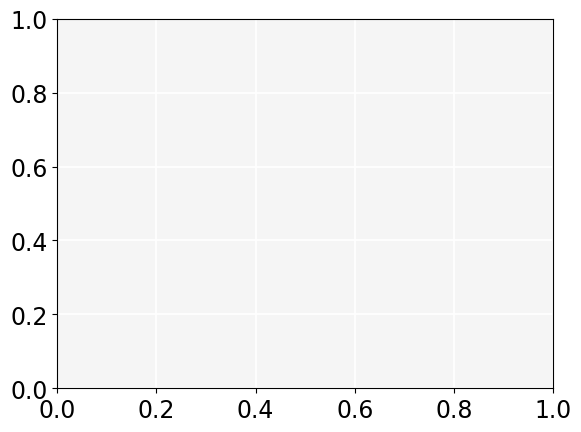

In [7]:
# Record once every 100 iterations, and 10 workers need to communicate in each iteration
original_num = 1000
print("original communication number:", original_num)

TASGS_data = pd.read_csv("./result/"+"TASGS-res-cifar10-iter-84.csv")
SASG_data = pd.read_csv("./result/"+"SASG-res-cifar10-iter-84.csv")
LASG_data = pd.read_csv("./result/"+"LASG-res-cifar10-iter-84.csv")
sparse_data = pd.read_csv("./result/"+"Sparse-res-cifar10-iter-84.csv")
sgd_data = pd.read_csv("./result/"+"SGD-res-cifar10-iter-84.csv")

TASGS_skip = TASGS_data['Skip'].values.tolist()
SASG_skip = SASG_data['Skip'].values.tolist()
LASG_skip = LASG_data['Skip'].values.tolist()


comm_round_TASGS = []
comm_round_SASG = []
comm_round_LASG = []
comm_round_sparse = []
comm_round_dis = []

comm_bit_TASGS = []
comm_bit_SASG = []
comm_bit_LASG = []
comm_bit_sparse = []
comm_bit_dis = []

comm_num_TASGS, comm_num_SASG, comm_num_LASG, comm_num_sparse, comm_num_dis = 0, 0, 0, 0, 0
for i in range(len(TASGS_skip)):
    comm_num_TASGS += original_num
    comm_num_SASG += original_num
    comm_num_LASG += original_num
    comm_num_sparse += original_num
    comm_num_dis += original_num
    
    comm_round_TASGS.append(comm_num_TASGS - TASGS_skip[i])
    comm_round_SASG.append(comm_num_SASG - SASG_skip[i])
    comm_round_LASG.append(comm_num_LASG - LASG_skip[i])
    comm_round_sparse.append(comm_num_sparse)
    comm_round_dis.append(comm_num_dis)

font1 = {'weight': 'normal', 'size': 17}
font2 = {'weight': 'normal', 'size': 20}
plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='both', linewidth=1.2)
plt.plot(comm_round_dis, sgd_data['test-acc'].values.tolist(), 'black', label='SGD', linewidth=2.5)
plt.plot(comm_round_sparse, sparse_data['test-acc'].values.tolist(), 'b', label='Sparse', linewidth=2.5)
plt.plot(comm_round_LASG, LASG_data['test-acc'].values.tolist(), 'g', label='LASG', linewidth=2.5)
plt.plot(comm_round_SASG, SASG_data['test-acc'].values.tolist(), 'r', label='SASG', linewidth=2.5)
plt.plot(comm_round_TASGS, TASGS_data['test-acc'].values.tolist(), 'c', label='GSASG', linewidth=2.5)

ax = plt.gca()
xmajorLocator = MultipleLocator(50000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(25000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)
plt.ylim(30, 95)
ymajorLocator = MultipleLocator(15)  # major
ax.yaxis.set_major_locator(ymajorLocator)
yminorLocator = MultipleLocator(15)  # minor
ax.yaxis.set_minor_locator(yminorLocator)
plt.ylabel('Test Accuracy', font2)
legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.13, right=0.95, bottom=0.15, top=0.95)
plt.savefig("./result/"+"test_res_cifar10.png", dpi=600)
plt.show()


plt.figure()
plt.rc('font', size=17)
plt.subplot(facecolor="whitesmoke")
plt.grid(axis="x", color='w', linestyle='-', which='major', linewidth=1.2)
plt.grid(axis="y", color='w', linestyle='-', which='major', linewidth=1.2)
plt.plot(comm_round_dis, sgd_data['Loss'].values.tolist(), 'black', label='SGD', linewidth=2.5)
plt.plot(comm_round_sparse, sparse_data['Loss'].values.tolist(), 'b', label='Sparse', linewidth=2.5)
plt.plot(comm_round_LASG, LASG_data['Loss'].values.tolist(), 'g', label='LASG', linewidth=2.5)
plt.plot(comm_round_SASG, SASG_data['Loss'].values.tolist(), 'r', label='SASG', linewidth=2.5)
plt.plot(comm_round_TASGS, TASGS_data['Loss'].values.tolist(), 'c', label='GSASG', linewidth=2.5)

ax = plt.gca()
xmajorLocator = MultipleLocator(50000)  # major
ax.xaxis.set_major_locator(xmajorLocator)
xminorLocator = MultipleLocator(25000)  # minor
ax.xaxis.set_minor_locator(xminorLocator)
ax.ticklabel_format(axis='x', style='scientific', scilimits=(0, 0))
plt.xlabel('Communication Round', font2)
plt.yscale('log')
plt.ylabel('Loss', font2)
legend = plt.legend(prop=font1)
plt.subplots_adjust(left=0.16, right=0.95, bottom=0.15, top=0.95)
plt.savefig("./result/"+"loss_res_cifar10.png", dpi=600)
plt.show()